# Analyzing Wordle Simulations

## Goal to create optimal wordle guessing strategy
**Key steps**
1. Build solver that can score all potential guesses based on a variety of features
2. Create simulation capability to run many games with psuedo random guessing scoring each guess by the variety of features
3. Use results from simulation to understand impact of variety of features on key game goals...
    1. Likelihood of a given word to be the correct guess
    2. Estimated value of a given word in reducing guesses remaining

**Key assumptions**
* I will build everything with a self-made version of wordle that accepts any alphanumeric word of a given length. This means it will be _worse_ at purely helping with the game of wordle (as I will train on a wider corpus than the actual wordle corpus)
* My wordleGame picks one of the top 10,000 most common English words for a given length using `get_frequency_dict('en', wordlist='best')`. Guesses can come from any of the words in that corpus
* I choose to set this up to play on hard mode. This means that each subsequent guess _must_ use information obtained in prior guesses. https://www.gamerevolution.com/guides/699992-wordle-hard-mode-how-to-turn-on-differences-harder-expert

In [2]:
# Importing relevant libraries
import pandas
import json
import matplotlib
from matplotlib import pyplot
import seaborn as sns
import random
from wordleSimulator import run_simulation
import numpy as np

#### Step 1: Build wordleSolver

You can find the wordleSolver I created elsewhere in this directory. The key information on the solver are the features that I ended up scoring against.

**Data we track**
* Game relevant data: information we have at this point in the game
    1. `turn_number`: which turn we are on in the game
    2. `words_possible`: how many potential words remain in our corpus
    3. `letter_in`: set of letters we confirmed **are** in the word
    4. `letter_out`: set of letters we confirmed are **not** in the word
    5. `pos_yes`: array of sets for letters we confirmed **are** in a given position (e.g green boxes)
    6. `pos_no`: array of sets for letters we confirmed are **not** a given position (e.g grey or yellow boxes)


* Guess: information we have for each potential guess
    1. `freq`: the word_frequency of a given word from the word_frequency corpus
    2. `letter_scores_by_word`: after each guess we take all the remaining possible words and count how many of each letter is in the remaining potential word list. We then give each potential guess a score if it includes the most common remaining letters
    3. `letter_scores_by_freq`: same as above, but weighting based on frequency of remaining words (e.g `their` will count more than `gyong` because it is much more frequently used
    4. `letter_scores_pos_perc`: similar to letter scores, but by frequency. If 50% of remaining words had a letter a second words with letter a second will get higher scores
    5. `letter_scores_pos_freq`: same as above, but weighted by frequency of remaining words

#### Step 2: Build simulation

You can find the wordleSimulation I created elsewhere in this directory. Most importantly in this section I will show the code I used to create the sample data I used to train various models.

**Please note: simulations will take a long time to ready, depending on your machine! It's worth testing how long it takes and deciding how big a simulation you want to run.**

In [ ]:
# Run 5,000 simulations. These simulations will be based on 100 starting words
# Each starting word will have 50 different wordleSolver's guess until we get the right word
# I did this in order to investigate differences based on randomness and attempt to understand
# What kind of strategies led to the slowest and fastest guesses for the same word

for i in range(100):
    run_simulation(n_letters=5, sims=50, same_word=True, random_guess = True, \
                   game_log='./simulations/gamelog_same_final_word.csv', \
                   turn_log='./simulations/turnlog_same_final_word.csv', start_word=None)


In [ ]:
# Run 1,000 simulations choosing a random starter word AND random guessing the whole way
for i in range(1000):
    run_simulation(n_letters=5, sims=1, same_word=False, random_guess = True, \
                   game_log='./simulations/gamelog_random_words_only.csv', \
                   turn_log='./simulations/turnlog_random_words_only.csv', start_word=None)
    

In [ ]:
# Run 1,000 simulations with a simple model that equally weights the four features we have `letter_score_by_word`,
# `letter_scores_by_freq`, `letter_scores_pos_perc`, `letter_scores_pos_freq`
# Run on the words that this model projects are the best starter words
top_model_words_to_test = ['their', 'about', 'other', 'after', 'years', 'great', 'those', 'raise', 'there', 'rates',
            'later', 'arise', 'aires', 'aries', 'arose', 'tears', 'stare', 'artie', 'irate', 'taser', 'aster', 'least',
            'first', 'oates', 'share', 'heart', 'arnie', 'reina', 'raine', 'einar', 'irena', 'earns', 'snare', 'nears',
            'arent', 'siena', 'anise', 'eason', 'earth', 'laser', 'learn', 'eatin', 'ariel', 'eaton', 'earls', 'reals', 'arles']

for w in top_model_words_to_test:
    print(f"Working on: {w}...")
    run_simulation(n_letters=5, sims=20, game_log='./simulations/gamelog_model.csv', turn_log='./simulations/turnlog_model.csv', start_word=w)

#### Step 3: Use results from simulation to understand various features on solving wordle

**Starting with game analysis for random guessing**

In [4]:
df = pandas.read_csv('./simulations/gamelog_same_final_word.csv')

In [7]:
# Number of games in this dataset
len(df)

5001

<AxesSubplot:>

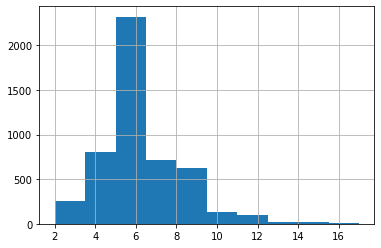

In [12]:
df['turns'].hist()

In [14]:
df.agg({'turns': ['mean', 'count', 'median', 'std']})

,turns
mean,5.988802
count,5001.000000
median,6.000000
std,1.972581


Overall - random guessing is surprisingly effective, at least when the guesses are restricted to possible words. Let's compare that to a very basic non-weighted modeled approach

In [15]:
df_base_model = pandas.read_csv('./simulations/gamelog_model.csv')

In [16]:
# Number of games in this dataset
len(df_base_model)

4701

<AxesSubplot:>

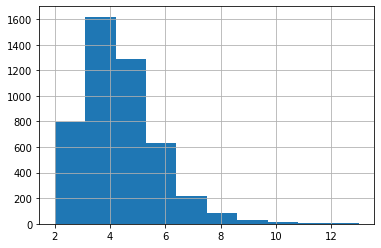

In [17]:
df_base_model['turns'].hist()

In [19]:
df_base_model.agg({'turns': ['mean', 'count', 'median', 'std']})

,turns
mean,4.641991
count,4701.000000
median,4.000000
std,1.324441


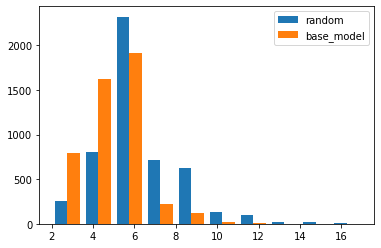

In [20]:
pyplot.hist([df['turns'],df_base_model['turns']], label=['random', 'base_model'])
pyplot.legend(loc='upper right')
pyplot.show()

But our very basic model does substantially better than random guessing. Let's now see if we can further improve on this basic ranking